In [6]:
import pandas as pd
from pandas import DataFrame
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import events
import visualise
import dataset
import numpy as np

# FILE = 'dataset/bob_all_processed_mins/2020_76.csv'
# FILE = 'dataset/transformed_timestamps/interval_15m/2020_100.csv'
# FILE = 'dataset/transformed_minutes/interval_15m/2020_118.csv'
FILE = 'dataset/bob_publication_data/events/died/preprocessed/died_m/43_2019-11-27 120000.csv'
RAW = True
df = pd.read_csv(FILE, dtype={
        't_i_1': float,
        't_i_2': float,
        't_i_3': float,
        't_i_4': float,
        't_o': float,
        'weight_kg': float,
        "weight_delta": float,
        'numeric.time': float,
        'h': float,
        't': float,
        'p': float,
    }, low_memory=False, parse_dates=['time'], index_col='time', date_format='%Y-%m-%d %H:%M:%S')
df = df.infer_objects(copy=False)


events_indexes = events.get_events_indexes(df) #events.get_parsed_event_indexes(df)
swarming_indexes = [pd.Timestamp(event) for event in events_indexes[0]]
queencell_indexes = [pd.Timestamp(event) for event in events_indexes[1]]
feeding_indexes = [pd.Timestamp(event) for event in events_indexes[2]]
honey_indexes = [pd.Timestamp(event) for event in events_indexes[3]]
treatment_indexes = [pd.Timestamp(event) for event in events_indexes[4]]
died_indexes = [pd.Timestamp(event) for event in events_indexes[5]]

print (f'Swarming {len(swarming_indexes)}: {swarming_indexes}')
print (f'Queencell {len(queencell_indexes)}: {queencell_indexes}')
print (f'Feeding {len(feeding_indexes)}: {feeding_indexes}')
print (f'Honey {len(honey_indexes)}: {honey_indexes}')
print (f'Treatment {len(treatment_indexes)}: {treatment_indexes}')
print (f'Died {len(died_indexes)}: {died_indexes}')
print ('========================================')
print(f"{df.index.min()}  ---  {df.index.max()}") 

Swarming 0: []
Queencell 0: []
Feeding 0: []
Honey 0: []
Treatment 0: []
Died 1: [Timestamp('2019-11-21 08:06:00')]
2019-09-11 11:03:00  ---  2019-11-25 09:59:00


# Visualize

In [7]:
start_date: pd.Timestamp =  df.index.min()
end_date: pd.Timestamp = df.index.max()
# start_date = pd.to_datetime('2019-9-22 10:00')
# end_date = pd.to_datetime('2019-9-26 16:00')
start_date, end_date

(Timestamp('2019-09-11 11:03:00'), Timestamp('2019-11-25 09:59:00'))

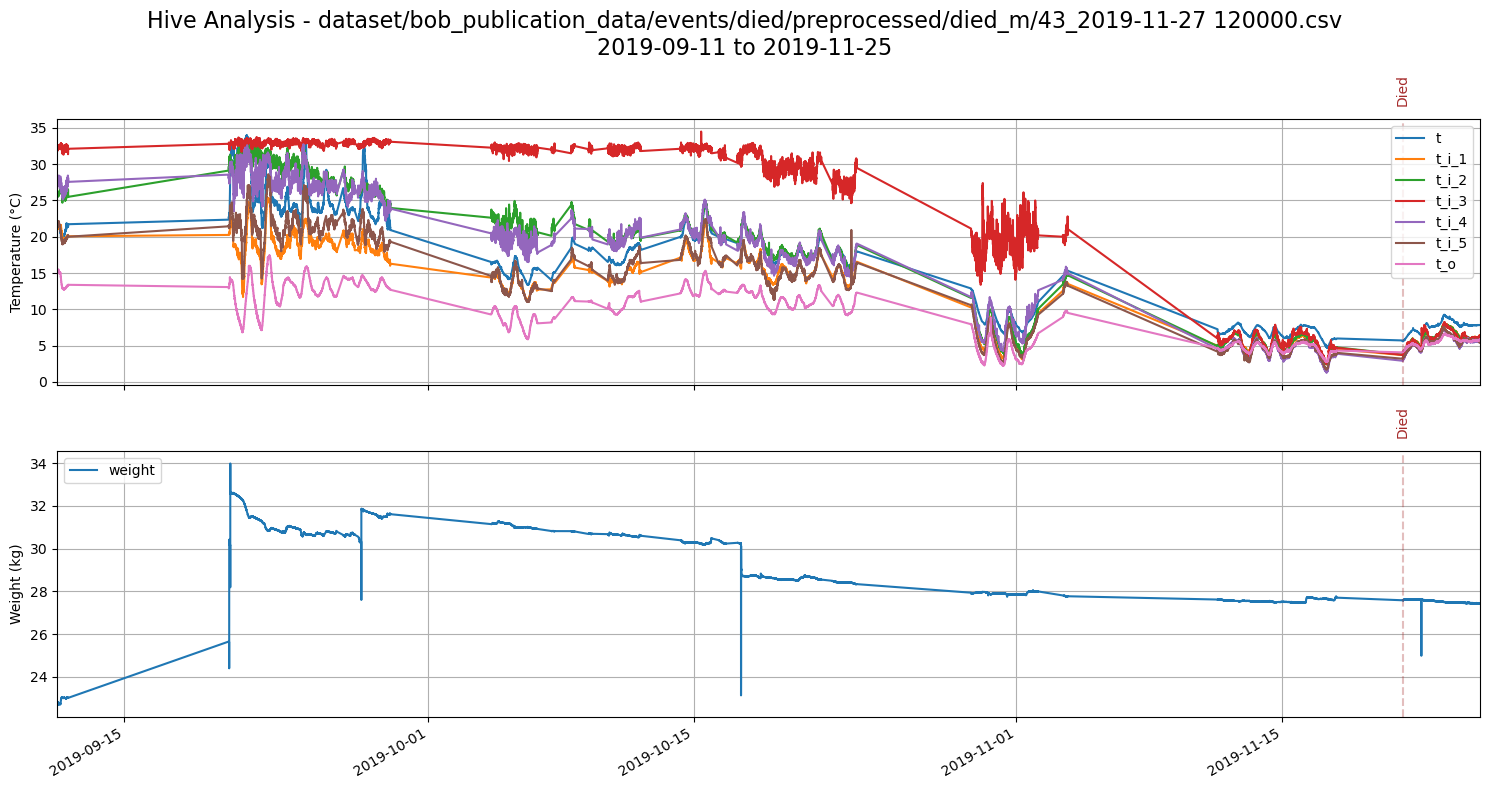

In [8]:
visualise.visualise(df, start_date, end_date, FILE, {
    'Swarming': swarming_indexes,
    'Queencell': queencell_indexes,
    'Feeding': feeding_indexes,
    'Honey': honey_indexes,
    'Treatment': treatment_indexes,
    'Died': died_indexes
})


# Fill values test

In [5]:
from scipy.interpolate import PchipInterpolator  # Preserves monotonicity
import numpy as np
def interpolate_with_dynamics(df, column):
    # Get valid indices and values
    valid_mask = df[column].notna()
    valid_points = df.index.astype(np.int64) // 10**9  # Convert to unix timestamp
    valid_points = valid_points[valid_mask]
    valid_values = df[column][valid_mask]
    
    if len(valid_values) < 4:  # If too few points, fall back to linear
        return df[column].interpolate(method='time')
    
    # Create PCHIP interpolator (Piecewise Cubic Hermite Interpolating Polynomial)
    interpolator = PchipInterpolator(valid_points, valid_values)
    
    # Interpolate all points
    all_points = df.index.astype(np.int64) // 10**9
    interpolated = interpolator(all_points)
    
    return pd.Series(interpolated, index=df.index)


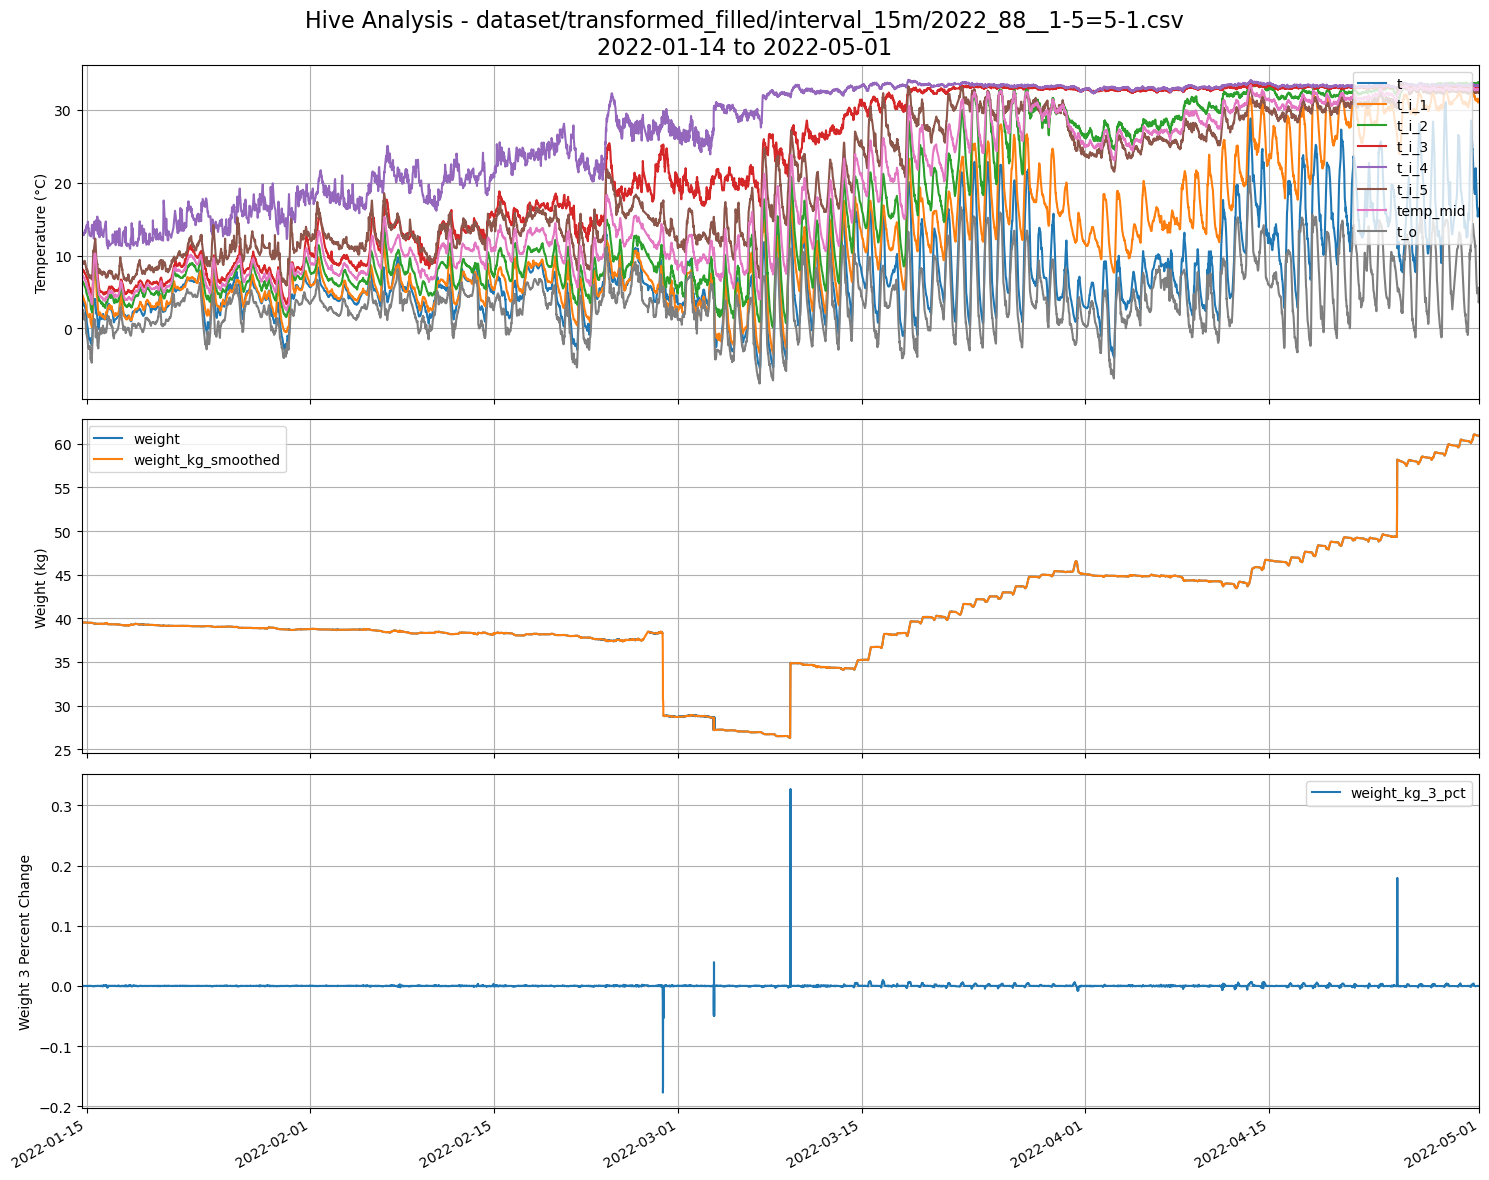

In [4]:
temp_columns = ['t_i_1', 't_i_2', 't_i_3', 't_i_4', 't_i_5', 't_o', 't', 'weight_kg']
if '2020_118__5-28=6-9__s' in FILE:
    df = dataset.fill_with_historical_pattern(df, ['t_i_1', 't_i_2', 't_i_3', 't_i_4', 't_i_5', 't_o', 't', 'weight_kg'], hours_ago=48)
if '2020_112__6-8=6-22__s' in FILE:
    df = dataset.fill_with_historical_pattern(df, ['t_o'], hours_ago=25)
# if '2022_88__1-1=5-1__' in FILE:
#     df = dataset.fill_with_historical_pattern(df, ['t_i_1', 't_i_2', 't_i_3', 't_i_4', 't_i_5', 't_o', 't', 'weight_kg'], hours_ago=24)

df['t'] = dataset.smooth_col(df['t'])
df['t_i_1'] = dataset.smooth_col(df['t_i_1'])
df['t_i_2'] = dataset.smooth_col(df['t_i_2'])
df['t_i_3'] = dataset.smooth_col(df['t_i_3'])
df['t_i_4'] = dataset.smooth_col(df['t_i_4'])
df['t_i_5'] = dataset.smooth_col(df['t_i_5'])
df['t_o'] = dataset.smooth_col(df['t_o'])
# df = fill_with_historical_pattern(df, temp_columns, hours_ago=48)

df['temp_mid'] = df[['t_i_1', 't_i_2', 't_i_3', 't_i_4', 't_i_5', 't']].median(axis=1, skipna=True)
df['weight_kg_smoothed'] = dataset.smooth_col(df['weight_kg'])
# df['weight_kg_smoothed'] = interpolate_with_dynamics(df, 'weight_kg')

df['weight_kg_3_pct'] = df['weight_kg_smoothed'].pct_change(periods=3)

visualise.visualise_filled(df, start_date, end_date, FILE, {
    'Swarming': swarming_indexes,
    'Queencell': queencell_indexes,
    'Feeding': feeding_indexes,
    'Honey': honey_indexes,
    'Treatment': treatment_indexes,
    'Died': died_indexes
})


# Slice useful 

In [608]:
# start_date = pd.to_datetime('2020-06-01')
# end_date = pd.to_datetime('2020-07-01')

df_slice = df.loc[start_date:end_date]
df_slice

,X.1,X,key,t_i_1,t_i_2,t_i_3,t_i_4,t_i_5,t_o,weight_kg,...,treatment.next.dif,died.next.dif,swarming.next.dif,swarming,queencell,feeding,honey,treatment,died,time.1
time,,,,,,,,,,,,,,,,,,,,,
2022-11-08 00:00:00,11438.0,447841.0,151.0,25.773000,33.295333,34.670000,33.962000,25.901000,5.586667,37.504933,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2022-11-08 00:00:00
2022-11-08 00:15:00,11453.0,447856.0,151.0,26.653333,32.884000,34.606667,33.963333,25.711333,5.472000,37.504800,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2022-11-08 00:15:00
2022-11-08 00:30:00,11468.0,447871.0,151.0,27.167333,33.006667,34.485667,34.028000,25.862333,5.524000,37.505567,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2022-11-08 00:30:00
2022-11-08 00:45:00,11483.0,447886.0,151.0,26.923000,33.333667,34.535667,34.293333,25.936667,5.427667,37.504833,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2022-11-08 00:45:00
2022-11-08 01:00:00,11498.0,447901.0,151.0,26.863333,32.880667,34.405333,34.198000,25.792000,5.224000,37.503700,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2022-11-08 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-04 23:00:00,49927.0,486661.0,151.0,2.150333,1.620000,1.888000,2.560000,3.380000,1.258000,35.837033,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2022-12-04 23:00:00
2022-12-04 23:15:00,49942.0,486676.0,151.0,2.120000,1.610000,1.880000,2.560000,3.380000,1.310000,35.835900,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2022-12-04 23:15:00
2022-12-04 23:30:00,49957.0,486691.0,151.0,2.120000,1.594000,1.880000,2.536000,3.380000,1.338000,35.835200,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2022-12-04 23:30:00


In [609]:
# fs = FILE.split('/')
# file = fs[-1].replace('2020_', '').replace('2019_', '').replace('2021_', '').replace('2022_', '').replace('.csv', '')
# output_filename = f"{file}_{start_date.strftime('%Y%m%d')}-{end_date.strftime('%m%d')}"
# df_slice.to_csv(f'dataset/_bob_useful_processed_mins/{output_filename}.csv')